### Description: this script is going to visualize the streamflow (and resultant return periods) for all Hydrobasins in Kenya given a specific date as input. Will test first with reanalysis data - can then apply to the reforecast

#### Step 1: Import Libraries

In [15]:
import datetime
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import gcsfs

#### Step 2: Load Files

In [2]:
# Function for opening zarr datasets
def open_zarr(path):
  return xr.open_zarr(
      store=path,
      chunks=None,
      storage_options=dict(token='anon')
      )

In [3]:
# Set file paths
base_directory = 'gs://flood-forecasting/hydrologic_predictions/model_id_8583a5c2_v0/'
reforecast_path = os.path.join(base_directory, 'reforecast/streamflow.zarr/')
reanalysis_path = os.path.join(base_directory, 'reanalysis/streamflow.zarr/')
return_periods_path = os.path.join(base_directory, 'return_periods.zarr/')
# Need to create hydrobasins file locally and place in data folder - have done for Kenya (made in QGIS)
hydrobasin_path = os.path.join(os.pardir, 'data', 'methodology_2', 'Kenya_hybas_L12.shp')

In [4]:
# Load files
reforecast_ds = open_zarr(reforecast_path)
reanalysis_ds = open_zarr(reanalysis_path)
return_periods_ds = open_zarr(return_periods_path)
hydrobasins = gpd.read_file(hydrobasin_path)

print(f'{reforecast_ds.sizes = }')
print(f'{reanalysis_ds.sizes = }')
print(f'{return_periods_ds.sizes = }')

hydrobasins.head()

C:\Users\Mark.DESKTOP-UFHIN6T\AppData\Local\Temp\ipykernel_13316\3731592437.py:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  return xr.open_zarr(


reforecast_ds.sizes = Frozen({'gauge_id': 1031646, 'issue_time': 2738, 'lead_time': 8})
reanalysis_ds.sizes = Frozen({'gauge_id': 1031646, 'time': 16063})
return_periods_ds.sizes = Frozen({'gauge_id': 1031646})


,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,...,hft_ix_s93,hft_ix_u93,hft_ix_s09,hft_ix_u09,gad_id_smj,gdp_ud_sav,gdp_ud_ssu,gdp_ud_usu,hdi_ix_sav,geometry
0,1121143370,1121143520,1120008100,1120008100,227.9,227.9,142.9,143.0,114210484000,0,...,29,29,93,93,208,525,0,0,390,"POLYGON ((40.97917 0.18333, 40.99076 0.18271, ..."
1,1122081850,1121143250,1120008100,1120008100,239.7,239.7,185.5,185.5,114210482200,0,...,25,25,90,90,208,514,0,0,389,"POLYGON ((40.96667 0.21667, 40.95927 0.21728, ..."
2,1121143780,1121143510,1120008100,1120008100,242.5,242.5,125.6,279.3,114210487100,0,...,30,25,95,89,208,690,0,6418712,414,"POLYGON ((40.98333 0.02083, 40.98333 0.025, 40..."
3,1121143630,1121143510,1120008100,1120008100,242.5,242.5,107.1,258.2,114210486100,0,...,30,28,100,98,208,413,0,0,375,"POLYGON ((40.98333 0.04583, 40.98002 0.04668, ..."
4,1122083890,1122083940,1120008100,1120008100,257.3,257.3,162.5,561.1,114210495000,0,...,27,22,95,88,208,795,0,0,428,"POLYGON ((41.02917 -0.16667, 41.02855 -0.16451..."


#### Step 3: Filter datasets by Kenyan hydrobasins

In [24]:
# Extract all the basin IDs in our HydroBasin dataset
kenya_basin_ids = hydrobasins['HYBAS_ID'].unique()
kenya_basin_ids = [f"hybas_{basin_id}" for basin_id in kenya_basin_ids]
# Get the gauge IDs from the reanalysis dataset.
reanalysis_ids = reanalysis_ds.gauge_id.values.astype(str)
# Find common basin IDs
common_ids = np.intersect1d(kenya_basin_ids, reanalysis_ids)
# Filter the reanalysis dataset using only the common IDs
filtered_reanalysis_ds = reanalysis_ds.sel(gauge_id=common_ids)
# Filter the return period dataset using the same IDs
filtered_return_periods_ds = return_periods_ds.sel(gauge_id=common_ids)

#### Step 4: Extract data for a specific date

In [25]:
# What date?
selected_date = "2020-01-05"

In [47]:
# Extract streamflow data for the selected date
streamflow_da = filtered_reanalysis_ds.streamflow.sel(time=selected_date)
# Convert to dataframe
streamflow_df = streamflow_da.to_dataframe().reset_index()
# Do the same for the return period dataset
return_periods_df = filtered_return_periods_ds.to_dataframe().reset_index()

#### Step 5: Calculate return period given streamflow

In [48]:
# Define function for running operation
def estimate_return_period(streamflow, gauge_id, rp_df):
    '''
    Function takes as input a streamflow value and interpolates the resultant return period
    from the RP dataframe for that specific hydrobasin
    '''
    # Filter row corresponding to the gauge_id
    row = rp_df[rp_df['gauge_id'] == gauge_id]
    if row.empty:
        return np.nan
    
    # Get all columns that start with "return_period_"
    rp_columns = [col for col in row.columns if col.startswith("return_period_")]
    
    # Create lists for the return period values and streamflow thresholds
    rp_values = []
    flow_thresholds = []
    for col in rp_columns:
        # extract numeric part of column name
        try:
            rp = float(col.split("_")[-1])
        except ValueError:
            continue
        rp_values.append(rp)
        flow_thresholds.append(row[col].values[0])
    
    # Convert to numpy arrays
    flow_thresholds = np.array(flow_thresholds)
    rp_values = np.array(rp_values)
    
    # Sort by flow thresholds
    sort_idx = np.argsort(flow_thresholds)
    flow_thresholds = flow_thresholds[sort_idx]
    rp_values = rp_values[sort_idx]
    
    # Check if streamflow is below the smallest threshold or above highest threshold
    if streamflow <= flow_thresholds[0]:
        return 0 # if it is below 2-year RP we will report 0
    if streamflow >= flow_thresholds[-1]:
        return rp_values[-1] # going to assume it's largest RP (200)
    
    # Linear interpolation for all other cases
    estimated_rp = np.interp(streamflow, flow_thresholds, rp_values)
    
    return estimated_rp

In [49]:
# Map the function across the streamflow dataframe
streamflow_df['estimated_rp'] = streamflow_df.apply(
    lambda row: estimate_return_period(row['streamflow'], row['gauge_id'], return_periods_df), axis=1
)

#### Step 6: Merge dataframes

In [56]:
# Only want to keep a few columns from original one
hydrobasins_subset = hydrobasins[['HYBAS_ID', 'UP_AREA', 'geometry']]
# Add an additional column that converts gauge ID to HYBAS_ID in the streamflow df
streamflow_df['HYBAS_ID'] = streamflow_df['gauge_id'].str.replace('hybas_', '', regex=False).astype(int)
merge_df = pd.merge(hydrobasins_subset, streamflow_df, on='HYBAS_ID', how='inner')
merge_df.head()

,HYBAS_ID,UP_AREA,geometry,gauge_id,time,streamflow,estimated_rp
0,1121143370,143.0,"POLYGON ((40.97917 0.18333, 40.99076 0.18271, ...",hybas_1121143370,2020-01-05,0.019959,0.0
1,1122081850,185.5,"POLYGON ((40.96667 0.21667, 40.95927 0.21728, ...",hybas_1122081850,2020-01-05,0.028260,0.0
2,1121143780,279.3,"POLYGON ((40.98333 0.02083, 40.98333 0.025, 40...",hybas_1121143780,2020-01-05,0.044512,0.0
3,1121143630,258.2,"POLYGON ((40.98333 0.04583, 40.98002 0.04668, ...",hybas_1121143630,2020-01-05,0.044250,0.0
4,1122083890,561.1,"POLYGON ((41.02917 -0.16667, 41.02855 -0.16451...",hybas_1122083890,2020-01-05,0.086635,0.0


#### Step 7: Plot the Maps

##### First just plotting streamflow

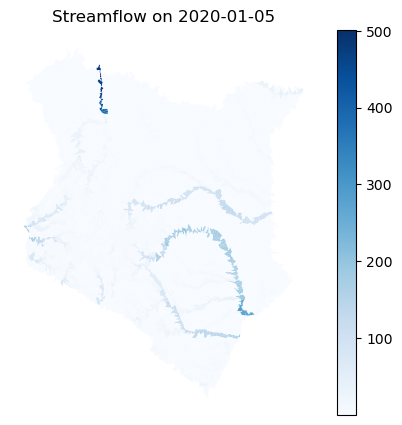

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
merge_df.plot(column='streamflow', cmap='Blues', legend=True, ax=ax)
ax.set_title(f"Streamflow on {selected_date}")
ax.axis('off')
plt.show()

##### Now plot by Return Period

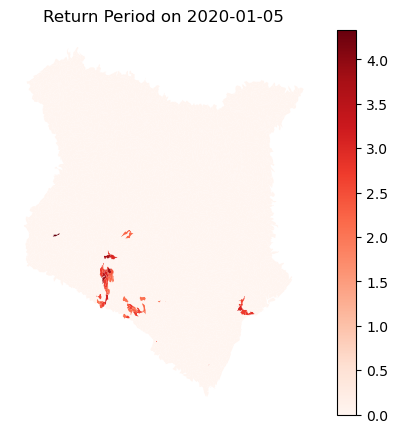

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
merge_df.plot(column='estimated_rp', cmap='Reds', legend=True, ax=ax)
ax.set_title(f"Return Period on {selected_date}")
ax.axis('off')
plt.show()